<a href="https://colab.research.google.com/github/Sank3t-Pand3y/Neural-Networks_with_Keras/blob/main/Building_Advanced_Transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import requests
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Layer, Dense, LayerNormalization, Dropout

## Setup the Enviornment to Generate Synthetic stock price data.

In [ ]:
import numpy as np
import pandas as pd

## Create a synthetic stock price dataset
np.random.seed(42)
data_length = 2000  ## You can adjust data length as needed
trend = np.linspace(100, 200, data_length)
noise = np.random.normal(0,2,data_length)
synthetic_data = trend + noise

## Create a DataFrame and save as "stock_price.csv"
data = pd.DataFrame(synthetic_data, columns=['Close'])
data.to_csv('stock_prices.csv', index=False)
print("Synthetic stock_prices.csv created and loaded.")

Synthetic stock_prices.csv created and loaded.


In [ ]:
## Load the dataset
data = pd.read_csv('stock_prices.csv')
data = data[['Close']].values

## Normalize the data
scaler = MinMaxScaler(feature_range=(0,1))
data = scaler.fit_transform(data)

## Prepare the data for training
def create_dataset(data, time_step = 1):
  X, Y = [],[]

  for i in range(len(data)-time_step-1):
    a = data[i:(i+time_step), 0]
    X.append(a)
    Y.append(data[i+time_step, 0])
  return np.array(X), np.array(Y)

time_step = 100  # Uses 100 previous days to predict the next day
X, Y = create_dataset(data, time_step)
X = X.reshape(X.shape[0], X.shape[1], 1)  # LSTM expects input in 3D format.

print("Shape of X:", X.shape)
print("Shape of Y:", Y.shape)



Shape of X: (1899, 100, 1)
Shape of Y: (1899,)


Note :

X is the input Sequence (Past Prices) &
Y is the output sequence (Next Prices)


(1899, 100,1 ) means (samples, time_steps, features)

(1899,) means samples

### Implement Multi Head Sel-Attention.

Define the Multi-Head Self-Attention mechanism.

In [ ]:
class MultiHeadSelfAttention(Layer):

    def __init__(self, embed_dim, num_heads=8):
        super(MultiHeadSelfAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.projection_dim = embed_dim // num_heads
        self.query_dense = Dense(embed_dim)
        self.key_dense = Dense(embed_dim)
        self.value_dense = Dense(embed_dim)
        self.combine_heads = Dense(embed_dim)


    def attention(self, query, key, value):
        score = tf.matmul(query, key, transpose_b=True)
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32)
        scaled_score = score / tf.math.sqrt(dim_key)
        weights = tf.nn.softmax(scaled_score, axis=-1)
        output = tf.matmul(weights, value)
        return output, weights

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        query = self.query_dense(inputs)
        key = self.key_dense(inputs)
        value = self.value_dense(inputs)
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)
        attention, _ = self.attention(query, key, value)
        attention = tf.transpose(attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(attention, (batch_size, -1, self.embed_dim))
        output = self.combine_heads(concat_attention)
        return output



In the above code:

- The MultiHeadSelfAttention layer implements the multi-head self-attention mechanism, which allows the model to focus on different parts of the input sequence simultaneously.

- The attention parameter computes the attention scores and weighted sum of the values.

- The split_heads parameter splits the input into multiple heads for parallel attention computation.

- The call method applies the self-attention mechanism and combines the heads.


## Implement Transformer block

define the transformer block.

In [ ]:
class TransformerBlock(Layer):

    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadSelfAttention(embed_dim, num_heads)
        self.ffn = tf.keras.Sequential([
            Dense(ff_dim, activation="relu"),
            Dense(embed_dim),
        ])

        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)


    def call(self, inputs, training):
        attn_output = self.att(inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In the above code:

- The TransformerBlock layer combines multi-head self-attention with a feed-forward neural network and normalization layers.  

- Dropout is used to prevent overfitting.

- The call method applies the self-attention, followed by the feedforward network with residual connections and layer normalization.


## Implement Encoder Layer

Define the Encoder layer.

In [ ]:
class EncoderLayer(Layer):

    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(EncoderLayer, self).__init__()
        self.att = MultiHeadSelfAttention(embed_dim, num_heads)
        self.ffn = tf.keras.Sequential([
            Dense(ff_dim, activation="relu"),
            Dense(embed_dim),
        ])

        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)



    def call(self, inputs, training):
        attn_output = self.att(inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)



In the above code:

- The EncoderLayer is similar to the TransformerBlock but is a reusable layer in the Transformer architecture.

- It consists of a MultiHeadSelfAttention mechanism followed by a feedforward neural network.

- Both sub-layers have residual connections around them, and layer normalization is applied to the output of each sub-layer.

- The call method applies the self-attention, followed by the feedforward network, with residual connections and layer normalization.


## Implement TRANSFORMER ENCODER.

Define the Transformer Encoder.

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Layer, Dense, LayerNormalization, Dropout

class MultiHeadSelfAttention(Layer):
    def __init__(self, embed_dim, num_heads=8):
        super(MultiHeadSelfAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.projection_dim = embed_dim // num_heads
        self.query_dense = Dense(embed_dim)
        self.key_dense = Dense(embed_dim)
        self.value_dense = Dense(embed_dim)
        self.combine_heads = Dense(embed_dim)


    def attention(self, query, key, value):
        score = tf.matmul(query, key, transpose_b=True)
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32)
        scaled_score = score / tf.math.sqrt(dim_key)
        weights = tf.nn.softmax(scaled_score, axis=-1)
        output = tf.matmul(weights, value)
        return output, weights


    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])


    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        query = self.query_dense(inputs)
        key = self.key_dense(inputs)
        value = self.value_dense(inputs)
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)
        attention, _ = self.attention(query, key, value)
        attention = tf.transpose(attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(attention, (batch_size, -1, self.embed_dim))
        output = self.combine_heads(concat_attention)
        return output

class TransformerBlock(Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadSelfAttention(embed_dim, num_heads)
        self.ffn = tf.keras.Sequential([
            Dense(ff_dim, activation="relu"),
            Dense(embed_dim),
        ])

        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)


    def call(self, inputs, training):
        attn_output = self.att(inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

class TransformerEncoder(Layer):
    def __init__(self, num_layers, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerEncoder, self).__init__()
        self.num_layers = num_layers
        self.embed_dim = embed_dim
        self.enc_layers = [TransformerBlock(embed_dim, num_heads, ff_dim, rate) for _ in range(num_layers)]
        self.dropout = Dropout(rate)

    def call(self, inputs, training=False):
        x = inputs
        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training=training)
        return x

# Example usage
embed_dim = 128
num_heads = 8
ff_dim = 512
num_layers = 4

transformer_encoder = TransformerEncoder(num_layers, embed_dim, num_heads, ff_dim)
inputs = tf.random.uniform((1, 100, embed_dim))
outputs = transformer_encoder(inputs, training=False)  # Use keyword argument for 'training'
print(outputs.shape)  # Should print (1, 100, 128)

(1, 100, 128)


## Build and compile the Transformer model.

Integrate the Transformer Encoder into a complete model for sequential data.

In [ ]:
# Define the necessary parameters

embed_dim = 128
num_heads = 8
ff_dim = 512
num_layers = 4

# Define the Transformer Encoder
transformer_encoder = TransformerEncoder(num_layers, embed_dim, num_heads, ff_dim)

# Build the model
input_shape = (X.shape[1], X.shape[2])
inputs = tf.keras.Input(shape=input_shape)

# Project the inputs to the embed_dim
x = tf.keras.layers.Dense(embed_dim)(inputs)
encoder_outputs = transformer_encoder(x)
flatten = tf.keras.layers.Flatten()(encoder_outputs)
outputs = tf.keras.layers.Dense(1)(flatten)
model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Summary of the model
model.summary()


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 100, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 100, 128)       │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_1           │ (None, 100, 128)       │       793,088 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 1)              │        12,801 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 806,145 (3.08 MB)

 Trainable params: 806,145 (3.08 MB)

 Non-trainable params: 0 (0.00 B)

In the above code:

- The Transformer Encoder model defines the necessary parameters, flattens the output, and ends with a dense layer to produce the final output.  

- The model is then compiled with the Adam optimizer and mean squared error loss.


## Train the Transformer model.
Train the model on the prepared dataset.

In [ ]:
# Train the model
model.fit(X, Y, epochs=20, batch_size=32)


Epoch 1/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 58s 733ms/step - loss: 9.8880
Epoch 2/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 89s 849ms/step - loss: 0.2460
Epoch 3/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 55s 910ms/step - loss: 0.2001
Epoch 4/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 51s 839ms/step - loss: 0.1639
Epoch 5/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 40s 674ms/step - loss: 0.1871
Epoch 6/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 41s 684ms/step - loss: 0.1181
Epoch 7/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 42s 686ms/step - loss: 0.1257
Epoch 8/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 41s 678ms/step - loss: 0.1926
Epoch 9/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 41s 678ms/step - loss: 0.1834
Epoch 10/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 46s 774ms/step - loss: 0.1280
Epoch 11/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 41s 678ms/step - loss: 0.1051
Epoch 12/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 42s 693ms/step - loss: 0.1184
Epoch 13/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 81s 680ms/step - loss: 0.0817
Epoch 14/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 42s 704ms/step - loss: 0.0907
Epoch 15/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 42s 

In the above code:

The model is trained on the normalized stock price data for 20 epochs with a batch size of 32.


## Evalaute and Make Predictions.

Evaluate the model's performance and make predictions on the dataset.

60/60 ━━━━━━━━━━━━━━━━━━━━ 14s 227ms/step


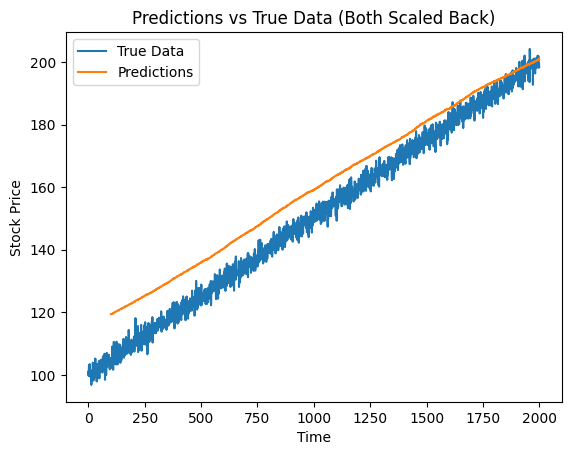

In [ ]:
# Make predictions
predictions = model.predict(X)
predictions = scaler.inverse_transform(predictions)

# Prepare true values for comparison
true_values = scaler.inverse_transform(data.reshape(-1, 1))

# Plot the predictions vs true values
import matplotlib.pyplot as plt

plt.plot(true_values, label='True Data')
plt.plot(np.arange(time_step, time_step + len(predictions)), predictions, label='Predictions')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.title('Predictions vs True Data (Both Scaled Back)')
plt.show()


In the above code:

- The model's predictions are transformed back to the original scale using the inverse transform of the scaler.

- The true data and predictions are plotted to visualize the model's performance.


### Add Dropout to the  Transformer model.

Note
Add a dropout layer after the Flatten layer in the model.
Set the dropout rate to 0.5

In [ ]:
from tensorflow.keras.layers import Dropout
## Add a dropout layer after the Flatten Layer
flatten = tf.keras.layers.Flatten()(encoder_outputs)
dropout = Dropout(0.5)(flatten)
outputs = tf.keras.layers.Dense(1)(dropout)

## Build the Model
model = tf.keras.Model(inputs, outputs)

## Compile the Model
model.compile(optimizer='adam', loss='mse')

## Train the Model
model.fit(X, Y, epochs=20, batch_size = 32)

## Evaluate the model
loss= model.evaluate(X, Y)
print(f'Test loss:{loss}')

Epoch 1/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 60s 711ms/step - loss: 3.0597
Epoch 2/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 41s 689ms/step - loss: 0.7188
Epoch 3/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 82s 683ms/step - loss: 0.2534
Epoch 4/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 41s 687ms/step - loss: 0.0961
Epoch 5/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 43s 709ms/step - loss: 0.0478
Epoch 6/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 41s 690ms/step - loss: 0.0418
Epoch 7/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 42s 701ms/step - loss: 0.0306
Epoch 8/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 42s 690ms/step - loss: 0.0323
Epoch 9/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 41s 690ms/step - loss: 0.0385
Epoch 10/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 43s 724ms/step - loss: 0.0245
Epoch 11/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 81s 701ms/step - loss: 0.0287
Epoch 12/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 41s 686ms/step - loss: 0.0254
Epoch 13/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 45s 749ms/step - loss: 0.0234
Epoch 14/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 78s 687ms/step - loss: 0.0236
Epoch 15/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 42s 